## Classification of Pneumonia in Chest X-rays

## Load Packages

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import roc_auc_score
from medmnist import PneumoniaMNIST, INFO
from torchvision import transforms


device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 64
epochs = 5
learning_rate = 1e-3
data_flag = "pneumoniamnist"
info = INFO[data_flag]


In [2]:
info

{'python_class': 'PneumoniaMNIST',
 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz?download=1',
 'MD5': '28209eda62fecd6e6a2d98b1501bb15f',
 'url_64': 'https://zenodo.org/records/10519652/files/pneumoniamnist_64.npz?download=1',
 'MD5_64': '8f4eceb4ccffa70c672198ea285246c6',
 'url_128': 'https://zenodo.org/records/10519652/files/pneumoniamnist_128.npz?download=1',
 'MD5_128': '05b46931834c231683c68f40c47b2971',
 'url_224': 'https://zenodo.org/records/10519652/files/pneumoniamnist_224.npz?download=1',
 'MD5_224': 'd6a3c71de1b94

## Split data

In [ ]:
# use_weight = False
use_weight = True
transform = transforms.Compose([
    transforms.Resize((224, 224)) if use_weight else transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = PneumoniaMNIST(split="train", transform=transform, download=True)
val_dataset   = PneumoniaMNIST(split="val",   transform=transform, download=True)
test_dataset  = PneumoniaMNIST(split="test",  transform=transform, download=True)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

n_classes = len(info['label'])




Using downloaded and verified file: C:\Users\lun\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\lun\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\lun\.medmnist\pneumoniamnist.npz


Preview data

Using downloaded and verified file: C:\Users\lun\.medmnist\pneumoniamnist.npz


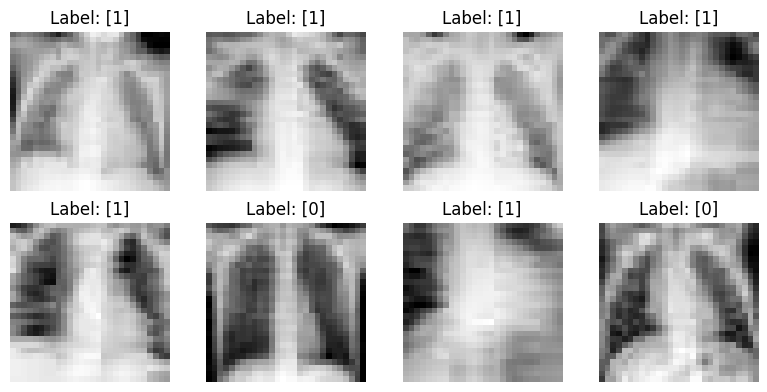

In [4]:
from medmnist import PneumoniaMNIST
import matplotlib.pyplot as plt
import numpy as np

train_dataset = PneumoniaMNIST(split="train", download=True, transform=None)

plt.figure(figsize=(8,4))
for i in range(8):
    img, label = train_dataset[i]

    img = np.array(img)   # ← Convert PIL to numpy

    plt.subplot(2,4,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Build Model

### SimpleCNN

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)



### Restnet18

In [6]:
def get_resnet18(num_classes):
    model = models.resnet18(pretrained=use_weight)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

### Restnet50

In [7]:
def get_resnet50(n_classes):
    model = models.resnet50(pretrained=use_weight)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, n_classes)
    return model

### EfficientNet-B0

In [8]:
def get_efficientnet_b0(num_classes):
    model = models.efficientnet_b0(pretrained=use_weight)
    # Change input conv to single-channel
    model.features[0][0] = nn.Conv2d(
        1, 32, kernel_size=3, stride=2, padding=1, bias=False
    )
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

### Vision Transformer

In [ ]:
def get_vit_b_16(n_classes):
    model = models.vit_b_16(pretrained=use_weight)
    model.conv_proj = nn.Conv2d(1, 768, kernel_size=16, stride=16)
    model.heads.head = nn.Linear(768,  n_classes)
    return model

### ConvNeXt-Tiny

In [10]:
def get_convnext_tiny(n_classes):
    model = models.convnext_tiny(pretrained=use_weight)
    model.features[0][0] = nn.Conv2d(1, 96, kernel_size=3, stride=2)
    model.classifier[2] = nn.Linear(model.classifier[2].in_features, n_classes)
    return model

## Model List

In [ ]:
models_dict = {
    # "SimpleCNN": SimpleCNN(n_classes),
    # "ResNet18": get_resnet18(n_classes),
    # "ResNet50": get_resnet50(n_classes),
    # "EfficientNetB0": get_efficientnet_b0(n_classes),
    "ViT_B_16": get_vit_b_16(n_classes),
    # "ConvNeXit_Tiny": get_convnext_tiny(n_classes),
}

c:\Users\lun\anaconda3\envs\self-attention\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lun\anaconda3\envs\self-attention\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training / Evaluation

In [12]:
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, optimizer):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.squeeze().long().to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()


def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.squeeze().long().to(device)
            out = model(x)
            
            _, pred = torch.max(out, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
            
            probs = torch.softmax(out, dim=1)
            all_preds.append(probs.cpu().numpy())
            all_labels.append(y.cpu().numpy())
    
    # ACC
    acc = correct / total
    
    # AUC
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    # Binary
    if all_preds.shape[1] == 2:
        auc = roc_auc_score(all_labels, all_preds[:, 1])
    # one-vs-rest
    else:
        auc = roc_auc_score(all_labels, all_preds, multi_class='ovr')
    
    return acc, auc



## Start Training

In [ ]:
results = {}

for name, model in models_dict.items():
    print(f"\n====================")
    print(f"TRAINING MODEL: {name}")
    print("====================")

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        train_one_epoch(model, optimizer)
        val_acc, val_auc = evaluate(model, val_loader)
        print(f"Epoch {epoch+1}/{epochs} - Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")

    final_test_acc, final_test_auc = evaluate(model, test_loader)
    results[name] = final_test_acc
    print(f"Final Test Accuracy ({name}): {final_test_acc:.4f}")
    print(f"Final Test AUC ({name}): {final_test_auc:.4f}")





TRAINING MODEL: ConvNeXit_Tiny
Epoch 1/5 - Val Acc: 0.7424, Val AUC: 0.8787
Epoch 2/5 - Val Acc: 0.8912, Val AUC: 0.9584
Epoch 3/5 - Val Acc: 0.8168, Val AUC: 0.9652
Epoch 4/5 - Val Acc: 0.9275, Val AUC: 0.9787


## Final Result

In [ ]:
print("\n====== MODEL PERFORMANCE COMPARISON ======")
for name, acc in results.items():
    print(f"{name:20s} : {acc:.4f}")

best_model = max(results, key=results.get)
print(f"Best Model: {best_model} (Acc = {results[best_model]:.4f})")